In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
import numpy as np
import torchvision.datasets as dset

In [73]:
# Load data

trans = transforms.ToTensor() 
train_set = dset.MNIST(root='MNIST',transform=trans, train=True,  download=True)
test_set = dset.MNIST(root='MNIST', transform=trans,train=False,  download=True)


batch_size = 1000

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)


train_size, image_h, image_w = train_set.train_data.size()

In [35]:
#Simple VAE model

class VAE(nn.Module):
    def __init__(self,dimZ,dimX):
        super(VAE, self).__init__()
        
        self.dimX = dimX
        self.dimZ = dimZ
        
        self.fc1 = nn.Sequential(
            nn.Linear(dimX, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU())
        self.fc21 = nn.Linear(1000, dimZ)
        self.fc22 = nn.Linear(1000, dimZ)
        self.fc3 = nn.Sequential(
            nn.Linear(dimZ, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU())
        self.fc41 = nn.Linear(1000, dimX)
        self.fc42 = nn.Linear(1000, dimX)
        self.sigmoid = nn.Sigmoid()

        
    def encode(self, x):
        h1 = self.fc1(x)
        mu, logsigma = self.fc21(h1), self.fc22(h1)
        return mu, logsigma

    def decode(self, z):
        h3 = self.fc3(z)
        h4 = self.fc41(h3)
        mu, logsigma = self.sigmoid(h4),self.fc42(h3)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        
        mu_z, logsigma_z = self.encode(x.view(-1, self.dimX))
        z = self.gaussian_sampler(mu_z.clone(), logsigma_z.clone())
        mu_x, logsigma_x = self.decode(z)
        return mu_x, logsigma_x, mu_z, logsigma_z

In [160]:
# VAE Loss

def KL_divergence(mu, logsigma):
    return -0.5*(1+2*logsigma-mu.pow(2)-(2*logsigma).exp()).sum()

def log_likelihood(x, mu, logsigma):
    
    c = math.log(1/(2*math.pi)**0.5)
    return (c-logsigma-((x-mu)**2)/(2*(2*logsigma).exp())).sum()

def loss_elbo(x, mu_x, logsigma_x, mu_z, logsigma_z,data_size):
    bs,*_ = x.size()
    return (-log_likelihood(x, mu_x, logsigma_x)+KL_divergence(mu_z, logsigma_z))*(data_size/bs)

Epoch 5


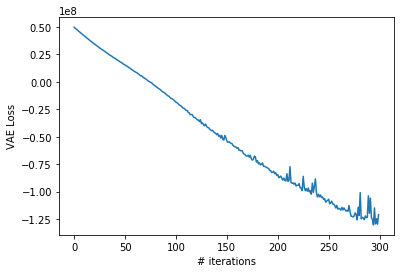

100%|██████████| 60/60 [00:31<00:00,  1.88it/s]


In [161]:
# VAE training

autoencoder = VAE(dimZ = 10,dimX = image_h*image_w)

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(),lr = 0.0001)

from tqdm import tqdm
from IPython import display
epochs = 5
losses = []

for epoch in range(epochs):
    for x_batch,_ in tqdm(train_loader):
        autoencoder.train()
        x_batch = x_batch.view(batch_size,-1)
        reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma = autoencoder(x_batch)
        loss = loss_elbo(x_batch, reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma,train_size)
        losses.append(float(loss))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        display.clear_output(wait=True)
        print("Epoch {}".format(epoch+1))
        plt.plot(losses)
        plt.xlabel("# iterations")
        plt.ylabel("VAE Loss")
        plt.show()
        

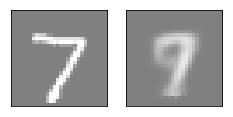

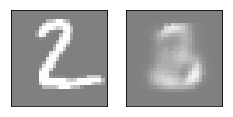

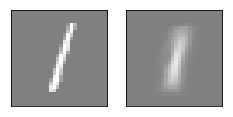

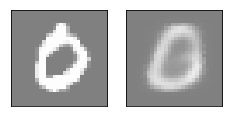

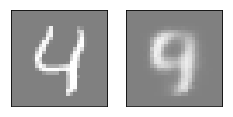

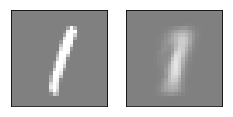

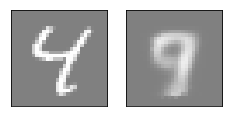

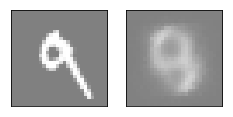

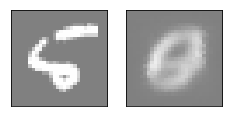

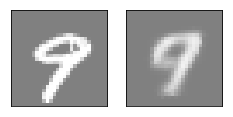

In [165]:
# Check generation quality


def plot_gallery(images, h, w, n_row=3, n_col=6,dim = 1):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
    plt.show()

vae = autoencoder
vae.eval()
for j, (X_batch,_) in enumerate(test_set):
    input = X_batch#.cuda())
    reconstruction_mu, _, _, _ = vae(input.view(1,-1))
    plot_gallery([X_batch.numpy(), np.clip(reconstruction_mu.data.numpy(),0,1)], image_h, image_w, n_row=1, n_col=2)
    if (j >= 9):
        break

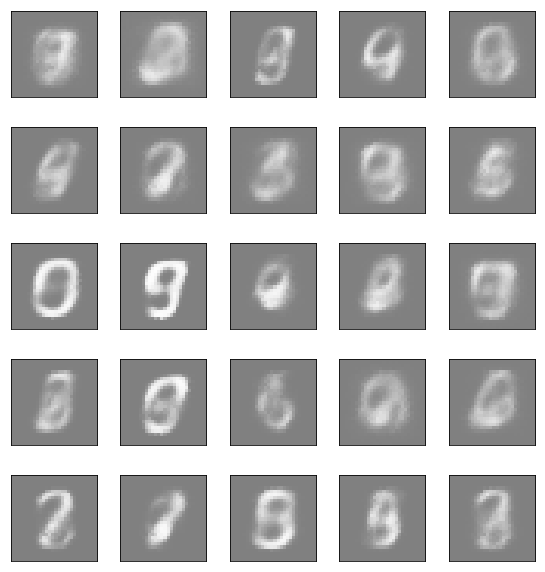

In [166]:
z = (np.random.randn(25, 10)).astype(np.float32)
output,_ = autoencoder.decode(torch.from_numpy(z))#.cuda()))
plot_gallery(np.clip(output.data.cpu().numpy(),0,1), image_h, image_w, n_row=5, n_col=5)

## 1. 1-D DISTRIBUTIONS

In [14]:
#Data generator

import torch.distributions as dist

class ShiftedExponential(dist.Exponential):
    def __init__(self, rate,shift, validate_args=None):
        self.shift = shift
        super(ShiftedExponential, self).__init__(rate, validate_args=None)
    def rsample(self, sample_shape=torch.Size()):
        s = super(ShiftedExponential, self).rsample(sample_shape)
        return s+self.shift

def get_dist(mean,var):
    l = dist.Laplace(mean,(var/2)**(1/2))
    u = dist.Uniform(mean-(3*var)**(1/2) ,mean+(3*var)**0.5)
    n = dist.Normal(mean,var**(1/2))
    e = ShiftedExponential((1/var)**(1/2),mean-var**(1/2))
    dists = [l,u,n,e]
    d_type = int(torch.randint(4,torch.Size([1])))
    return dists[d_type],d_type

def create_samples(num_samples,mean,var,cls = 0):
    l = dist.Laplace(mean,(var/2)**(1/2))
    u = dist.Uniform(mean-(3*var)**(1/2) ,mean+(3*var)**0.5)
    n = dist.Normal(mean,var**(1/2))
    e = ShiftedExponential((1/var)**(1/2),mean-var**(1/2))
    dists = [l,u,n,e]
    return dists[cls].sample(torch.Size([num_samples]))

def create_random_samples(num_dsets,num_samples):
    mean_dist = dist.Uniform(-0.1 ,0.1)
    var_dist = dist.Uniform(0.5 ,0.6)
    means = mean_dist.sample(torch.Size([num_dsets]))
    vars = var_dist.sample(torch.Size([num_dsets]))
    dsets = []
    dtypes = []
    for mean,var in zip(means,vars):
        current_dist, d_type = get_dist(mean,var)
        dset = current_dist.sample(torch.Size([num_samples]))
        dsets += dset,
        dtypes += d_type,
    return torch.stack(dsets), torch.tensor(dtypes)

num_dsets = 10000
num_samples = 200
train_size = num_dsets*num_samples
X,y = create_random_samples(num_dsets,num_samples)
X = X.unsqueeze(-1)
bs = 500

train_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.Tensor(X),y)),\
            batch_size=bs,shuffle=False)



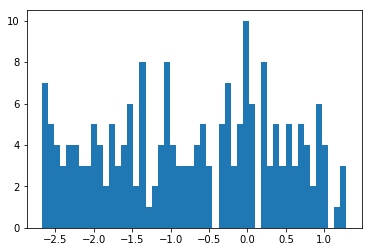

In [127]:
%matplotlib inline
x = X.data.numpy()[1].T[0]
plt.hist(x,50)
plt.show()

In [73]:
# Models

class ObservationDecoder(nn.Module):
    def __init__(self,dimX,dimZ,dimC,skip_order):
        super(ObservationDecoder, self).__init__()
        self.fc = nn.Sequential(nn.Linear(skip_order*dimZ+dimC,128),nn.ReLU(),nn.Linear(128,128),nn.ReLU(),nn.Linear(128,2*dimX))
    
    def forward(self,Z,c):
        input = torch.cat([Z,c],dim = -1)
        output = self.fc(input)
        mu,logsigma = torch.chunk(output,2,dim = -1)
        return mu,logsigma
    
class LatentDecoder(nn.Module):
    def __init__(self,dimZ,dimC):
        super(LatentDecoder, self).__init__()
        self.fc = nn.Sequential(nn.Linear(dimZ+dimC,128),nn.ReLU(),nn.Linear(128,128),nn.ReLU(),nn.Linear(128,2*dimZ))
    
    def forward(self,z_last,c):
        input = torch.cat([z_last,c],dim = -1)
        output = self.fc(input)
        mu,logsigma = torch.chunk(output,2,dim = -1)
        return mu,logsigma
    
class InferenceNetwork(nn.Module):
    def __init__(self,dimX,dimZ,dimC):
        super(InferenceNetwork, self).__init__()
        self.fc = nn.Sequential(nn.Linear(dimX+dimZ+dimC,128),nn.ReLU(),nn.Linear(128,128),nn.ReLU(),nn.Linear(128,2*dimZ))
    
    def forward(self,x,z_last,c):
        input = torch.cat([x,z_last,c],dim = -1)
        output = self.fc(input)
        mu,logsigma = torch.chunk(output,2,dim = -1)
        return mu,logsigma

class StatisticNetwork(nn.Module):
    def __init__(self,dimX,dimC):
        super(StatisticNetwork, self).__init__()
        self.fc_instance_encoder = nn.Sequential(nn.Linear(dimX,128),nn.ReLU(),nn.Linear(128,128),nn.ReLU(),nn.Linear(128,128))
        self.fc_post_pooling = nn.Sequential(nn.Linear(128,128),nn.ReLU(),nn.Linear(128,128),nn.ReLU(),nn.Linear(128,2*dimC))
    
    def forward(self,x):
        e = self.fc_instance_encoder(x)
        v = e.mean(dim = -2)
        output = self.fc_post_pooling(v)
        mu,logsigma = torch.chunk(output,2,dim = -1)
        return mu,logsigma


    

    
class Statition(nn.Module):
    def __init__(self,observation_decoder,latent_decoder,inference_network,statistic_network,dimX,dimZ,dimC,skip_order):
        super(Statition, self).__init__()
        self.dimX = dimX
        self.dimZ = dimZ
        self.dimC = dimC
        self.skip_order = skip_order
        self.obsdec = observation_decoder(dimX,dimZ,dimC,skip_order)
        self.latdec= latent_decoder(dimZ,dimC)
        self.inference = inference_network(dimX,dimZ,dimC)
        self.statistic = statistic_network(dimX,dimC)
    
    @staticmethod
    def KL_divergence(mu1,logsigma1,mu2,logsigma2):
        return 0.5*(2*logsigma2-2*logsigma1-1+torch.exp(2*(logsigma1-logsigma2))+((mu2-mu1)**2)*torch.exp(-2*logsigma2)).sum()
    
    @staticmethod
    def gaussian_sampler(mu, logsigma,size = None):
        std = logsigma.exp()
        if size is None:
            size = mu.size()
        else:
            mu = mu.unsqueeze(-2).expand(size)
            std = std.unsqueeze(-2).expand(size)
        
        eps = torch.randn(size)
        return eps.mul(std).add(mu)
    
    def context_divergence(self,x):
        mu,logsigma = self.statistic(x)
        c_size = torch.tensor(x.size())
        c_size[-1] = mu.size()[-1]
        c_size = torch.Size(c_size)
        c = self.gaussian_sampler(mu.clone(),logsigma.clone(),c_size)
        Cd = self.KL_divergence(mu,logsigma,torch.zeros(mu.size()),torch.zeros(logsigma.size()))
        return Cd, c
    
    def latent_divergence(self,x,c):
        Z = torch.tensor([])
        Ld = 0
        z = torch.zeros(*x.size()[:-1],self.dimZ)
        for order in range(self.skip_order):
            mu_inf,logsigma_inf = self.inference(x,z,c)
            mu_lat,logsigma_lat = self.latdec(z,c)
            z = self.gaussian_sampler(mu_inf.clone(),logsigma_inf.clone())
            Z = torch.cat([Z,z],dim = -1)
            Ld += self.KL_divergence(mu_inf,logsigma_inf,mu_lat,logsigma_lat)
        
        return Ld, Z
        
        
    def reconstruction_loss(self,x,Z,c):
        mu, logsigma = self.obsdec(Z,c)
        const = math.log(1/(2*math.pi)**0.5)
        return (const-logsigma-((x-mu)**2)/(2*((2*logsigma).exp()))).sum()
        
    def forward(self,x,dset_num):
        batch_size,sample_size = x.size()[:2]
        Cd, c = self.context_divergence(x)
        Ld, Z = self.latent_divergence(x,c)
        Rd = self.reconstruction_loss(x,Z,c)
        return (Rd-Ld-Cd)*(dset_num/batch_size)
    
    def generate_simalar(self,X,num_samples):
        c,_ = self.statistic(X)
        X_gen = torch.tensor([])
        for sample in range(num_samples):
            Z = torch.tensor([])
            z = torch.zeros(self.dimZ)
            for order in range(self.skip_order):
                mu_z,logsigma_z = self.latdec(z,c)
                z = self.gaussian_sampler(mu_z.clone(),logsigma_z.clone())
                Z = torch.cat([Z,z],dim = -1)
            mu_x, logsigma_x = self.obsdec(Z,c)
            x_new = self.gaussian_sampler(mu_x.clone(),logsigma_x.clone()).unsqueeze(0)
            X_gen = torch.cat([X_gen,x_new],dim = 0)
        return X_gen
    
gen = Statition(ObservationDecoder,LatentDecoder,InferenceNetwork,StatisticNetwork\
               ,dimX = 1,dimZ = 32,dimC = 3,skip_order = 2)
gen(torch.rand(100,200,1),train_size),gen(X[:1000],train_size),X[:1000].size()

gen.generate_simalar(X[0],5)


TypeError: 'int' object is not callable

In [15]:
# Model Training

import torch.utils.data

model = Statition(ObservationDecoder,LatentDecoder,InferenceNetwork,StatisticNetwork\
               ,dimX = 1,dimZ = 32,dimC = 3,skip_order = 1)
opt = torch.optim.Adam(model.parameters(),lr = 0.01)

history = []


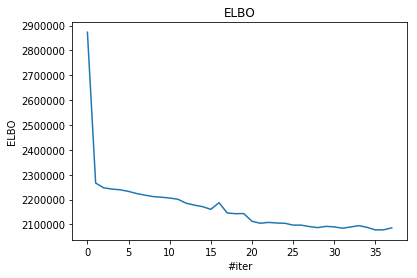

tensor(2087818., grad_fn=<NegBackward>)
tensor(2093406.7500, grad_fn=<NegBackward>)
tensor(2090595., grad_fn=<NegBackward>)
tensor(2068304.3750, grad_fn=<NegBackward>)
tensor(2086655.7500, grad_fn=<NegBackward>)
tensor(2100157., grad_fn=<NegBackward>)
tensor(2062498.5000, grad_fn=<NegBackward>)
tensor(2092173.8750, grad_fn=<NegBackward>)
tensor(2072779.7500, grad_fn=<NegBackward>)
tensor(2088790.2500, grad_fn=<NegBackward>)
tensor(2075068.1250, grad_fn=<NegBackward>)
tensor(2065405.2500, grad_fn=<NegBackward>)
tensor(2085038.2500, grad_fn=<NegBackward>)
tensor(2089728.6250, grad_fn=<NegBackward>)
tensor(2062010.2500, grad_fn=<NegBackward>)


KeyboardInterrupt: 

In [16]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline



def train_network(model,train_loader,num_epoch = 10000):
    for epoch in range(num_epoch):
        i=0
        epoch_histiory = []
        
        for X_batch, _ in train_loader:
            model.train()
            # compute loss
            loss = -model(X_batch,num_dsets)
            print(loss)

            # train with backprop
            
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        
            epoch_histiory.append(float(loss))
        history.append(np.mean(epoch_histiory))
        i+=1
        if i%1==0:
            clear_output(True)
            plt.title("ELBO")
            plt.plot(np.array(history))
            plt.ylabel('ELBO')
            plt.xlabel('#iter')
            plt.show()
            i+=1

    history.append(float(loss))
    
    clear_output(True)
    plt.title("ELBO")
    plt.plot(np.array(history))
    plt.ylabel('ELBO')
    plt.xlabel('#epoch')
    plt.show()
    
train_network(model,train_loader)


In [8]:
# Classification performance for distributions ['r','b','g','y'] -> [l,u,n,e] dists
from mpl_toolkits.mplot3d import Axes3D

def show_c(X,group):
    %matplotlib notebook
    coors = []
    colors = []    
    for Xs,ys in zip(X,y):
        coors += model.statistic(Xs)[0].data.numpy(),
            
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x_min,y_min,z_min = np.min(coors,axis = 0)
    x_max,y_max,z_max = np.max(coors,axis = 0)
    ax.set_xlim(x_min,x_max)
    ax.set_ylim(y_min,y_max)
    ax.set_zlim(z_min,z_max)
    
    groups = ['r','b','g','y']
    labels = ['Laplacian','Uniform','Normal','Exponential']
    cdict = {1: 'red', 2: 'blue', 3: 'green'}
    scatter_x,scatter_y,scatter_z = np.array(coors).T
    ax = fig.add_subplot(111, projection='3d')
    for g in np.unique(group):
        ix = np.where(group.data.numpy() == g)
        ax.scatter(scatter_x[ix], scatter_y[ix], scatter_z[ix], c = groups[g], label = labels[g])
    
    plt.legend()
    plt.show()



<IPython.core.display.Javascript object>


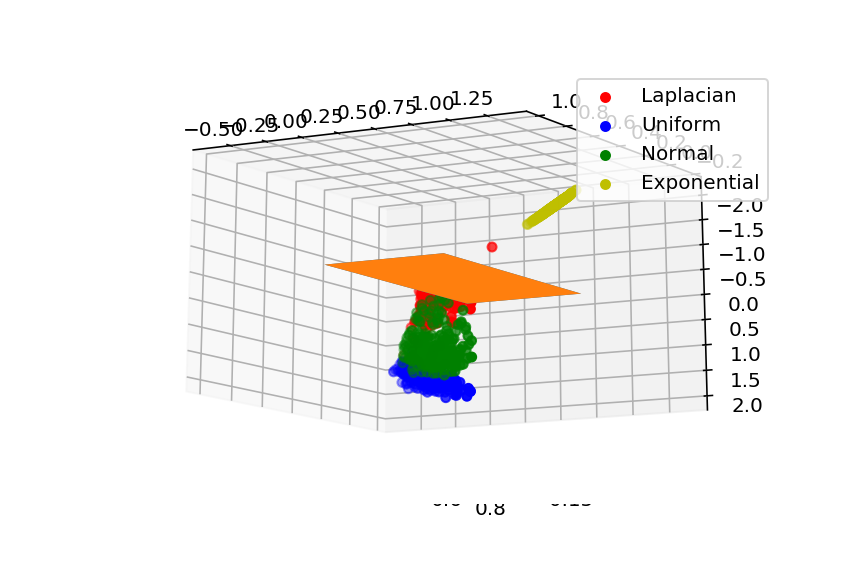

In [18]:
show_c(X[:1000],y[:1000])

### 2. MNIST

In [56]:
# Data generator

trans = transforms.ToTensor() 
train_set = dset.MNIST(root='MNIST',transform=trans, train=True,  download=True)
test_set = dset.MNIST(root='MNIST', transform=trans,train=False,  download=True)

In [57]:
normalizer = train_set.train_data.float().sum(dim = (-1,-2))
dataset_dists = train_set.train_data.float()/normalizer.unsqueeze(-1).unsqueeze(-1).expand(train_set.train_data.shape)


In [91]:
def sample_coors(size,image,coors):
    image = image.reshape(-1)
    p = image/image.sum()
    sample_inds = np.random.choice(range(len(coors)),size = size,p = p)
    sample_coors = coors[sample_inds]
    random_noise =  np.random.rand(*sample_coors.shape)
    coors = sample_coors+random_noise
    return coors

def sample_dsets(images,sample_size,dset_size):
    im_size = images[0].shape
    X,Y = np.mgrid[0:im_size[0],0:im_size[1]]
    exact_coors = np.c_[Y.reshape(-1),X.reshape(-1)[::-1]]
    im_indecs = np.random.randint(len(images),size = dset_size)
    dsets = []
    real_im = []
    for im_inx in im_indecs:
        im_sample = sample_coors(sample_size,images[im_inx],exact_coors)
        dsets += im_sample,
        real_im += images[im_inx],
    return np.array(dsets),np.array(real_im)
    
num_dsets = 40000
num_samples = 50
train_size = num_dsets*num_samples
X,y = sample_dsets(train_set.train_data.numpy(),num_samples,num_dsets)
bs = 500
train_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.Tensor(X),torch.Tensor(y))),\
            batch_size=bs,shuffle=False)



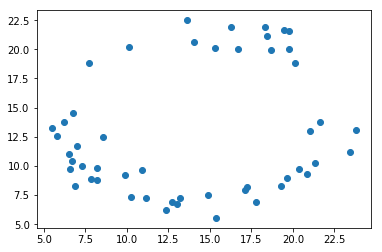

In [95]:
%matplotlib inline
plt.plot(*X[3].T,'o')
plt.show()

In [96]:
# Model 

class ObservationDecoder(nn.Module):
    def __init__(self,dimX,dimZ,dimC,skip_order):
        super(ObservationDecoder, self).__init__()
        self.fc = nn.Sequential(nn.Linear(skip_order*dimZ+dimC,256),nn.ReLU(),nn.Linear(256,256),nn.ReLU(),nn.Linear(256,2*dimX))
    
    def forward(self,Z,c):
        input = torch.cat([Z,c],dim = -1)
        output = self.fc(input)
        mu,logsigma = torch.chunk(output,2,dim = -1)
        return mu,logsigma
    
class LatentDecoder(nn.Module):
    def __init__(self,dimZ,dimC):
        super(LatentDecoder, self).__init__()
        self.fc = nn.Sequential(nn.Linear(dimZ+dimC,256),nn.ReLU(),nn.Linear(256,256),nn.ReLU(),nn.Linear(256,2*dimZ))
    
    def forward(self,z_last,c):
        input = torch.cat([z_last,c],dim = -1)
        output = self.fc(input)
        mu,logsigma = torch.chunk(output,2,dim = -1)
        return mu,logsigma
    
class InferenceNetwork(nn.Module):
    def __init__(self,dimX,dimZ,dimC):
        super(InferenceNetwork, self).__init__()
        self.fc = nn.Sequential(nn.Linear(dimX+dimZ+dimC,256),nn.ReLU(),nn.Linear(256,256),nn.ReLU(),nn.Linear(256,2*dimZ))
    
    def forward(self,x,z_last,c):
        input = torch.cat([x,z_last,c],dim = -1)
        output = self.fc(input)
        mu,logsigma = torch.chunk(output,2,dim = -1)
        return mu,logsigma

class StatisticNetwork(nn.Module):
    def __init__(self,dimX,dimC):
        super(StatisticNetwork, self).__init__()
        self.fc_instance_encoder = nn.Sequential(nn.Linear(dimX,256),nn.ReLU(),nn.Linear(256,256),nn.ReLU(),nn.Linear(256,256))
        self.fc_post_pooling = nn.Sequential(nn.Linear(256,256),nn.ReLU(),nn.Linear(256,256),nn.ReLU(),nn.Linear(256,2*dimC))
    
    def forward(self,x):
        e = self.fc_instance_encoder(x)
        v = e.mean(dim = -2)
        output = self.fc_post_pooling(v)
        mu,logsigma = torch.chunk(output,2,dim = -1)
        return mu,logsigma

In [97]:
#train network
model = Statition(ObservationDecoder,LatentDecoder,InferenceNetwork,StatisticNetwork\
               ,dimX = 2,dimZ = 2,dimC = 64,skip_order = 3)
opt = torch.optim.Adam(model.parameters(),lr = 0.001)

history = []


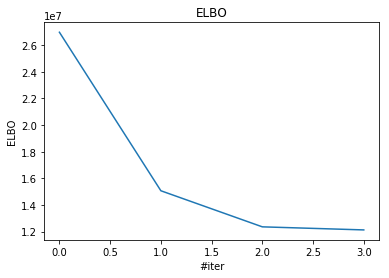

tensor(12107754., grad_fn=<NegBackward>)
tensor(12086541., grad_fn=<NegBackward>)
tensor(12101842., grad_fn=<NegBackward>)
tensor(12085326., grad_fn=<NegBackward>)
tensor(12082138., grad_fn=<NegBackward>)
tensor(12126222., grad_fn=<NegBackward>)
tensor(12159550., grad_fn=<NegBackward>)
tensor(12096614., grad_fn=<NegBackward>)
tensor(12086580., grad_fn=<NegBackward>)
tensor(12065705., grad_fn=<NegBackward>)
tensor(12116104., grad_fn=<NegBackward>)
tensor(12073604., grad_fn=<NegBackward>)
tensor(12043064., grad_fn=<NegBackward>)
tensor(12086584., grad_fn=<NegBackward>)
tensor(12071275., grad_fn=<NegBackward>)
tensor(12108399., grad_fn=<NegBackward>)
tensor(12031266., grad_fn=<NegBackward>)
tensor(12087715., grad_fn=<NegBackward>)
tensor(12042990., grad_fn=<NegBackward>)
tensor(12148442., grad_fn=<NegBackward>)
tensor(12058622., grad_fn=<NegBackward>)
tensor(12092135., grad_fn=<NegBackward>)
tensor(12089408., grad_fn=<NegBackward>)
tensor(12055192., grad_fn=<NegBackward>)
tensor(12074872.

In [ ]:
train_network(model,train_loader)

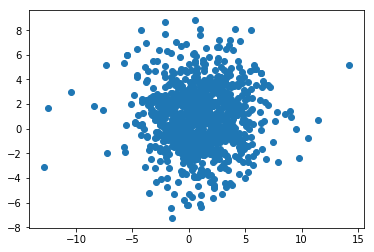

In [90]:
# Generation

image = model.generate_simalar(torch.FloatTensor(X[8]),1000).data.numpy()

%matplotlib inline
plt.plot(*image.T,'o')
plt.show()